This implementation is adapted from stathwang's FPMC repository: https://github.com/stathwang/FPMC

## Code Implementation

In [1]:
import pandas as pd
import numpy as np
from multiprocessing import cpu_count
from joblib import Parallel, delayed
import time
from scipy.stats import expon
import math
import matplotlib.pyplot as plt


In [2]:
# Load the dataset: beauty 2023
dat = pd.read_csv("beauty23_clean.csv")

In [3]:
# Load the dataset:
dat2 = dat[['usr', 'prod']]

# Remove users with low rating activity and rare items
np.random.seed(321)
min_usr = 1
min_prod = 5
#filter user that only appear once
dat2 = dat2[dat2['usr'].isin(dat2['usr'].value_counts()[dat2['usr'].value_counts() > min_usr].index)]
#filter product that appears less than 5 times
dat2 = dat2[dat2['prod'].isin(dat2['prod'].value_counts()[dat2['prod'].value_counts() > min_prod].index)]
#filter user that only appear once
dat2 = dat2[dat2['usr'].isin(dat2['usr'].value_counts()[dat2['usr'].value_counts() > min_usr].index)]
dat2

# Split data into train, dev, test
def split_data(dat2, test_prop=0.05, dev_prop=0.15, seed=123):
    np.random.seed(seed)
    dat_split = {}
    for usr, group in dat2.groupby('usr'):
        n = len(group) #number of unique users
        test_idx = group.index[-int(n * test_prop):] # last 20% for that user
        remaining_idx = group.index[:-int(n * test_prop)]# first 80% for that user
        dev_idx = remaining_idx[-int(len(remaining_idx) * dev_prop / (1 - test_prop)):]
        train_idx = remaining_idx[:-len(dev_idx)]
        dat_split[usr] = {
            'test': group.loc[test_idx],
            'dev': group.loc[dev_idx],
            'train': group.loc[train_idx]
        }
    return dat_split

dat_split = split_data(dat2, test_prop=0.15, dev_prop=0.05, seed=321)

train = pd.concat([x['train'] for x in dat_split.values()])
dev = pd.concat([x['dev'] for x in dat_split.values()])
test = pd.concat([x['test'] for x in dat_split.values()])

# Look-up dictionaries for users and products
all_prods = train['prod'].unique()
prod2idx = {prod: idx for idx, prod in enumerate(all_prods)} 
idx2prod = {idx: prod for idx, prod in enumerate(all_prods)} 

all_users = train['usr'].unique()
usr2idx = {usr: idx for idx, usr in enumerate(all_users)} 
idx2usr = {idx: usr for idx, usr in enumerate(all_users)}

train['usr_idx'] = train['usr'].map(usr2idx)
train['prod_idx'] = train['prod'].map(prod2idx)

# Retrieve the top 1% of products as popular products
pop_prods = train.groupby(['prod', 'prod_idx']).size().reset_index(name='N').nlargest(int(len(train) * 0.01), 'N')

# If a product in dev or test set does not appear in training, assign a fixed prod_idx of zero
dev['usr_idx'] = dev['usr'].map(usr2idx)
dev['prod_idx'] = dev['prod'].map(prod2idx)
dev = dev[dev['prod_idx'].notna()]

test['usr_idx'] = test['usr'].map(usr2idx)
test['prod_idx'] = test['prod'].map(prod2idx)
test = test[test['prod_idx'].notna()]


In [4]:
# FPMC: Factorized Personalized Markov Chains
# This function trains an FPMC model based on sequential basket data.

def fpmc(dat2, k_cf=32, k_mc=32,
        reg=0, init_sigma=1,
        learning_rate=0.5, learning_rate_decay=1,
        maxiters=100, maxtime=float('inf'),
        sampling_bias=100, adaptive_sampling=True,
        seed=123):
    """
    Parameters:
    dat2: The dataset containing user-product interaction data. 
    k_cf: Dimensionality of the latent factors for the Collaborative Filtering component.
    k_mc: Dimensionality of the latent factors for the Markov Chain component.
    reg: Regularization parameter to prevent overfitting. It applies L2 regularization to the latent factors.
    init_sigma: Standard deviation used for initializing the latent factor matrices with random values.
    learning_rate: Initial learning rate for the gradient descent optimization.
    learning_rate_decay: Factor to decay the learning rate after each iteration. A value of 1 disables decay.
    maxiters: Maximum number of iterations for the training loop.
    maxtime: Maximum training time in minutes. Training will stop when the time exceeds this limit.
    sampling_bias: Scale parameter for the exponential distribution used in adaptive sampling.
    adaptive_sampling: Set to True, use adaptive sampling based on ranking and variance of the latent factors. 

    Returns:
        A dictionary containing the trained latent factor matrices and training metrics:
        - 'avg_cost': Average error over iterations
        - 'current_absolute_cost': Error per iteration
        - 'current_delta': Update magnitude per iteration
        - 'V_user_prod': User-product latent factor matrix (CF)
        - 'V_prod_user': Product-user latent factor matrix (CF)
        - 'V_prev_next': Previous-next product transition matrix (MC)
        - 'V_next_prev': Next-previous product transition matrix (MC)
        - 'k_cf': Latent dimensionality for CF
        - 'k_mc': Latent dimensionality for MC
    """

    # Record the start time for time-constrained training
    starttime = time.time()

    # Determine the number of unique users and products in the dataset
    n_users = dat2['usr'].nunique()
    n_prods = dat2['prod'].nunique()

    # Initialize latent factors for Collaborative Filtering (CF) and Markov Chain (MC) components
    np.random.seed(seed)
    V_user_prod = init_sigma * np.random.randn(n_users, k_cf)  # User-product interaction matrix (CF)
    V_prod_user = init_sigma * np.random.randn(n_prods, k_cf)  # Product-user interaction matrix (CF)
    V_prev_next = init_sigma * np.random.randn(n_prods, k_mc)  # Previous-next product transitions (MC)
    V_next_prev = init_sigma * np.random.randn(n_prods, k_mc)  # Next-previous product transitions (MC)

    # Initialize variables for tracking progress during training
    iters = 1
    avg_cost = np.zeros(maxiters)  # Average training cost per iteration
    current_absolute_cost = np.zeros(maxiters)  # Absolute error per iteration
    current_delta = np.zeros(maxiters)  # Model update magnitude per iteration

    # Map users to indices for efficient lookups
    all_users = dat2['usr'].unique()
    usr2idx = {user: idx for idx, user in enumerate(all_users)}  # 0-indexing for users

    while iters <= maxiters and time.time() - starttime < 60 * maxtime:
        # Apply learning rate decay if specified
        if learning_rate_decay < 1:
            learning_rate *= learning_rate_decay

        # Adaptive sampling: adjust ranking and variance for efficient sampling
        if adaptive_sampling and iters % int(n_prods * math.log(n_prods)) == 1:
            CF_rank = np.argsort(V_prod_user, axis=0)  # CF component ranking
            MC_rank = np.argsort(V_next_prev, axis=0)  # MC component ranking
            ranks = np.hstack((CF_rank, MC_rank))      # Combined ranking for sampling

            CF_var = np.var(V_prod_user, axis=0)       # Variance of CF features
            MC_var = np.var(V_next_prev, axis=0)       # Variance of MC features
            vars = np.concatenate((CF_var, MC_var))    # Combined variance vector

        # Sample a random user and their product sequence
        user = np.random.choice(all_users)
        user_id = usr2idx[user]
        user_prod_ids = dat2[dat2['usr'] == user]['prod_idx'].values

        # Randomly select a product pair: previous and true next
        rand = np.random.randint(0, len(user_prod_ids) - 1)
        prev_prod = user_prod_ids[rand] 
        true_next = user_prod_ids[rand + 1] 

        # Generate a false negative sample using adaptive
        if adaptive_sampling:
            while True:
                rank = expon.rvs(scale=sampling_bias)  # Sample rank using exponential distribution
                while math.ceil(rank) >= n_prods:
                    rank = expon.rvs(scale=sampling_bias)  # Ensure rank is within bounds
                factor_signs = np.sign(np.concatenate((V_user_prod[user_id], V_prev_next[prev_prod])))
                factor_prob = np.abs(np.concatenate((V_user_prod[user_id], V_prev_next[prev_prod]))) * vars
                f = np.random.choice(k_cf + k_mc, p=factor_prob / np.sum(factor_prob))
                mult = math.ceil(rank) * factor_signs[f]
                if mult < 0:
                    mult = mult + n_prods + 1
                if int(mult) < len(ranks):
                    false_next = ranks[int(mult), f]  # Selected product ID
                if false_next != true_next:
                    break
        else:
            false_next = np.random.randint(0, n_prods - 1)
            if false_next >= true_next:
                false_next += 1

        # Compute errors for true and false negative examples
        x_true = np.sum(V_user_prod[user_id] * V_prod_user[true_next]) + \
                 np.sum(V_prev_next[prev_prod] * V_next_prev[true_next])
        x_false = np.sum(V_user_prod[user_id] * V_prod_user[false_next]) + \
                  np.sum(V_prev_next[prev_prod] * V_next_prev[false_next])
        absolute_error = x_false - x_true
        delta = 1 - 1 / (1 + math.exp(min(10, max(-10, absolute_error))))

        # Update latent factors for CF and MC components using gradient descent
        V_user_prod_mem = V_user_prod[user_id].copy()
        V_user_prod[user_id] += learning_rate * (delta * (V_prod_user[true_next] - V_prod_user[false_next]) - reg * V_user_prod[user_id])
        V_prod_user[true_next] += learning_rate * (delta * V_user_prod_mem - reg * V_prod_user[true_next])
        V_prod_user[false_next] += learning_rate * (-delta * V_user_prod_mem - reg * V_prod_user[false_next])

        V_prev_next_mem = V_prev_next[prev_prod].copy()
        V_prev_next[prev_prod] += learning_rate * (delta * (V_next_prev[true_next] - V_next_prev[false_next]) - reg * V_prev_next[prev_prod])
        V_next_prev[true_next] += learning_rate * (delta * V_prev_next_mem - reg * V_next_prev[true_next])
        V_next_prev[false_next] += learning_rate * (-delta * V_prev_next_mem - reg * V_next_prev[false_next])

        # Track and log progress
        current_absolute_cost[iters - 1] = absolute_error
        current_delta[iters - 1] = delta
        avg_cost[iters - 1] = np.mean(np.concatenate((current_absolute_cost[:iters], [absolute_error])))

        iters += 1

    # Return trained model parameters and metrics
    return {
        'avg_cost': avg_cost,
        'current_absolute_cost': current_absolute_cost,
        'current_delta': current_delta,
        'V_user_prod': V_user_prod,
        'V_prod_user': V_prod_user,
        'V_prev_next': V_prev_next,
        'V_next_prev': V_next_prev,
        'k_cf': k_cf,
        'k_mc': k_mc
    }


In [5]:
train_dict = fpmc(train, k_cf=128, k_mc=128,learning_rate=0.02, learning_rate_decay=0.6, maxiters=10000)

In [6]:
# Top-k recommendation function
def top_k(dat2, users, V_user_prod, V_prod_user, V_prev_next, V_next_prev,
          top_k=10, excluded_prods=None, parallel=False):
    """
    
    Parameters:
    - dat2: The dataset containing user-product interactions.

    - users: List of user identifiers for whom recommendations are to be generated.

    - V_user_prod: User-product latent factor matrix (Collaborative Filtering).

    - V_prod_user: Product-user latent factor matrix (Collaborative Filtering).

    - V_prev_next: Previous-to-next product transition matrix (Markov Chain).

    - V_next_prev:  Next-to-previous product transition matrix (Markov Chain).

    - top_k: Number of top recommendations to generate for each user.

    - excluded_prods: List of product identifiers to exclude from recommendations.

    - parallel: If True, process recommendations in parallel using multiple CPU cores.

    Returns: 
        A DataFrame containing the top-k recommendations for each user, with the following columns:
        - 'usr': User identifier
        - 'usr_idx': User index
        - 'prod': Recommended product identifier
        - 'prod_idx': Recommended product index
        - 'score': Recommendation score
    """

    # Filter the dataset to include only the specified users
    dat_trunc = dat2[dat2['usr'].isin(users)]
    # Group the data by user for processing
    dat_trunc = [group for _, group in dat_trunc.groupby('usr')]

    def process_user(x):
        """
        Parameters:
        - x: Subset of dat2 containing data for a single user.

        Returns:
        - Top-k recommendations for the user.
        """
        # Retrieve user ID and associated index
        user = x['usr'].iloc[0]
        uid = x['usr_idx'].iloc[0]
        # Extract the list of products viewed by the user and the last viewed product
        viewed_prod_ids = x['prod_idx'].values
        last_prod_id = x['prod_idx'].iloc[-1]

        # Compute recommendation scores by combining CF and MC components
        uid = int(uid) 
        last_prod_id = int(last_prod_id)  # Ensure proper integer indexing
        scores = V_user_prod[uid].dot(V_prod_user.T) + \
                 V_prev_next[last_prod_id].dot(V_next_prev.T)

        # Exclude specified products from recommendations, if any
        if excluded_prods is not None:
            excluded_prod_ids = [prod2idx[prod] for prod in excluded_prods]
            scores[excluded_prod_ids] = -np.inf  # Assign very low score to excluded products

        # Rank products based on their scores and retrieve the top-k
        ranked_prod_ids = np.argsort(scores)[::-1][:top_k]  # Sort in descending order
        output = pd.DataFrame({
            'usr': [user] * top_k,                       # User identifier repeated for top-k products
            'usr_idx': [uid] * top_k,                   # User index repeated for top-k products
            'prod': [idx2prod[idx] for idx in ranked_prod_ids],  # Map indices to product identifiers
            'prod_idx': ranked_prod_ids,                # Product indices for top-k recommendations
            'score': scores[ranked_prod_ids]            # Scores corresponding to top-k products
        })
        return output

    # Process all users' data in parallel or sequentially
    if parallel:
        recommend = Parallel(n_jobs=cpu_count()-1)(delayed(process_user)(x) for x in dat_trunc)
    else:
        recommend = [process_user(x) for x in dat_trunc]

    # Combine recommendations for all users into a single DataFrame
    return pd.concat(recommend, ignore_index=True)


In [7]:
# Helper function to find if a user buys any item in our predicted set
def hr_calculater(data, usr, k):
    pred_df = top_k(data, [usr], train_dict['V_user_prod'], train_dict['V_prod_user'], train_dict['V_prev_next'], train_dict['V_next_prev'],
          top_k=k, excluded_prods=None, parallel=False)
    set_pred = set(pred_df['prod_idx'])
    set_true = set(data[data['usr'] == usr]['prod_idx'])
    num_correct = len(set_true.intersection(set_pred))
    return 1 if num_correct > 0 else 0

In [8]:
# Find HR@15
hit_num = 0
test_lst = list(set(train['usr'].unique()).intersection(set(test['usr'].unique())))
for usr in test_lst:
    hit_num += hr_calculater(test, usr, 15)
print("HR@15 is ", hit_num/len(test_lst))

HR@15 is  0.2222222222222222


In [9]:
# Find HR@10
hit_num = 0
for usr in test_lst:
    hit_num += hr_calculater(test, usr, 10)
print("HR@10 is ", hit_num/len(test_lst))

HR@10 is  0.1111111111111111


In [10]:
# Find HR@5
hit_num = 0
for usr in test_lst:
    hit_num += hr_calculater(test, usr, 5)
print("HR@5 is ", hit_num/len(test_lst))

HR@5 is  0.037037037037037035


# Visualizations

### HR@15

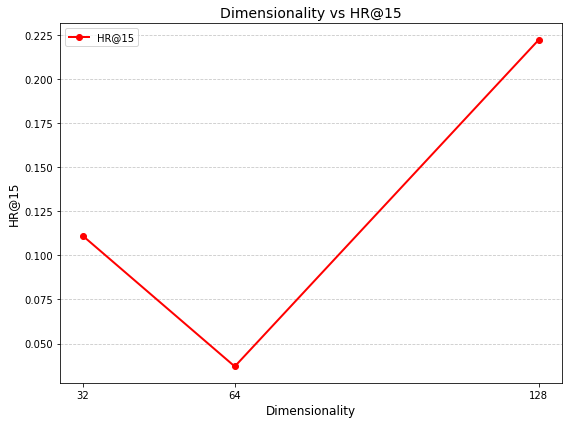

In [11]:
dimensionality = [32, 64, 128]
hr_values = []

for dimension in dimensionality:
    train_dict = fpmc(train, k_cf=dimension, k_mc=dimension,learning_rate=0.02, learning_rate_decay=0.6, maxiters=10000) 
    hit_num = 0
    test_lst = list(set(train['usr'].unique()).intersection(set(test['usr'].unique())))
    for usr in test_lst:
        hit_num += hr_calculater(test, usr, 15)
    hr_values.append(hit_num/len(test_lst))

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(dimensionality, hr_values, marker='o', label='HR@15', color='red', linewidth=2)

# Customizing the plot
plt.title("Dimensionality vs HR@15", fontsize=14)
plt.xlabel("Dimensionality", fontsize=12)
plt.ylabel("HR@15", fontsize=12)
plt.xticks(dimensionality, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()

### HR@10

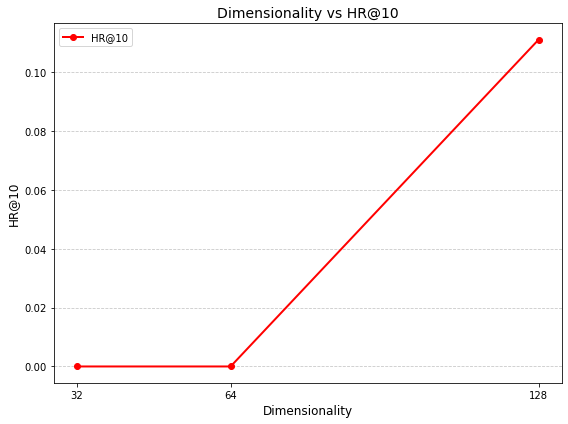

In [12]:
dimensionality = [32, 64, 128]
hr_values = []

for dimension in dimensionality:
    train_dict = fpmc(train, k_cf=dimension, k_mc=dimension,learning_rate=0.02, learning_rate_decay=0.6, maxiters=10000) 
    hit_num = 0
    test_lst = list(set(train['usr'].unique()).intersection(set(test['usr'].unique())))
    for usr in test_lst:
        hit_num += hr_calculater(test, usr, 10)
    hr_values.append(hit_num/len(test_lst))

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(dimensionality, hr_values, marker='o', label='HR@10', color='red', linewidth=2)

# Customizing the plot
plt.title("Dimensionality vs HR@10", fontsize=14)
plt.xlabel("Dimensionality", fontsize=12)
plt.ylabel("HR@10", fontsize=12)
plt.xticks(dimensionality, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()

### HR@5

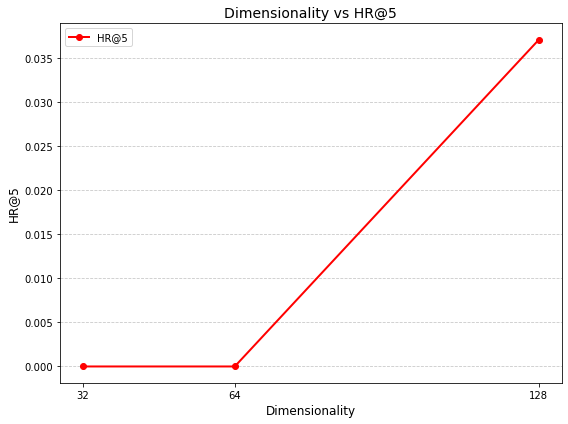

In [13]:
dimensionality = [32, 64, 128]
hr_values = []

for dimension in dimensionality:
    train_dict = fpmc(train, k_cf=dimension, k_mc=dimension,learning_rate=0.02, learning_rate_decay=0.6, maxiters=10000) 
    hit_num = 0
    test_lst = list(set(train['usr'].unique()).intersection(set(test['usr'].unique())))
    for usr in test_lst:
        hit_num += hr_calculater(test, usr, 5)
    hr_values.append(hit_num/len(test_lst))

# Create a plot
plt.figure(figsize=(8, 6))
plt.plot(dimensionality, hr_values, marker='o', label='HR@5', color='red', linewidth=2)

# Customizing the plot
plt.title("Dimensionality vs HR@5", fontsize=14)
plt.xlabel("Dimensionality", fontsize=12)
plt.ylabel("HR@5", fontsize=12)
plt.xticks(dimensionality, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()